In [ ]:
import torch
# torch.cuda.is_available()
!pip install transformers
!pip install jieba
!pip install focal_loss_torch
!pip install nltk

import nltk
import re
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

import jieba

from focal_loss.focal_loss import FocalLoss


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    get_linear_schedule_with_warmup,
    BertConfig,
    BertModel,
    BertPreTrainedModel,
    BertTokenizer,)

from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors
from transformers.data.processors.utils import InputExample, DataProcessor

In [ ]:
import logging
logger=logging.getLogger(__name__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pre-Processing

In [ ]:
import pandas as pd
import json
# Using pandas to read the JSON 
df = pd.read_json('/content/drive/MyDrive/Wisers/iflytek_public/train.json',lines=True)
df.head()

,label,label_des,sentence
0,11,薅羊毛,活动新用户领5元现金即日起成功注册酷划的新用户，填写邀请码80008即可领取5元现金奖励哦。...
1,95,借贷,产品简介小腰包APP是友戏互联为年轻白领人群打造的一款互联网消费金融应用，以用户日常消费行为...
2,74,违章,6000万车主都在用的查违章洗车养车加油车险优惠一站式用车服务平台，河南交警系统直连特色功能...
3,70,工具,这不仅是一个一站式的服务平台，在使用魅族手机过程中遇到什么可以通过这个应用来寻求解决，还是您...
4,58,高等教育,"""2019普通话学习、教师、公务员、播音主持、学拼音、配音员做普通话水平测试的优选软件1.普..."


In [ ]:
df.shape

(12133, 3)

In [ ]:
# check missing value
df = df[df.sentence.notnull()]
df = df[df.label_des.notnull()]
df = df[df.label.notnull()]
df.shape

(12133, 3)

In [ ]:
# drop the label_des
df.drop(columns = ['label_des'] , inplace = True)
df.head()

,label,sentence
0,11,活动新用户领5元现金即日起成功注册酷划的新用户，填写邀请码80008即可领取5元现金奖励哦。...
1,95,产品简介小腰包APP是友戏互联为年轻白领人群打造的一款互联网消费金融应用，以用户日常消费行为...
2,74,6000万车主都在用的查违章洗车养车加油车险优惠一站式用车服务平台，河南交警系统直连特色功能...
3,70,这不仅是一个一站式的服务平台，在使用魅族手机过程中遇到什么可以通过这个应用来寻求解决，还是您...
4,58,"""2019普通话学习、教师、公务员、播音主持、学拼音、配音员做普通话水平测试的优选软件1.普..."


In [ ]:
import re
def clear_character(sentence):
    pattern1='[a-zA-Z0-9]'
    pattern2 = '\[.*?\]'
    pattern3 = re.compile(u'[^\s1234567890:：' + '\u4e00-\u9fa5]+')
    pattern4='[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
    # line1=re.sub(pattern1,'',sentence)   
    line2=re.sub(pattern2,'',sentence)  
    line3=re.sub(pattern3,'',line2)   
    line4=re.sub(pattern4, '', line3) 
    new_sentence=''.join(line4.split()) 
    return new_sentence

In [ ]:
# delete the stopwords and punctuations
nltk.download('stopwords')
stop_words = stopwords.words('chinese')
sen_stop = []
for s in df['sentence']:
    sen_stop.append( clear_character(''.join([w for w in s.split() if w not in stop_words])))
df['sentence'] = sen_stop
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,sentence
0,11,活动新用户领5元现金即日起成功注册酷划的新用户填写邀请码80008即可领取5元现金奖励哦小伙...
1,95,产品简介小腰包是友戏互联为年轻白领人群打造的一款互联网消费金融应用以用户日常消费行为轨迹为信...
2,74,6000万车主都在用的查违章洗车养车加油车险优惠一站式用车服务平台河南交警系统直连特色功能专...
3,70,这不仅是一个一站式的服务平台在使用魅族手机过程中遇到什么可以通过这个应用来寻求解决还是您们身...
4,58,2019普通话学习教师公务员播音主持学拼音配音员做普通话水平测试的优选软件1普通话考试汇集普...


## EDA of data

In [ ]:
# import jionlp as jio

# google_api = jio.GoogleApi()


# apis = [google_api] 

# back_trans = jio.BackTranslation(mt_apis=apis)
# text = '2019普通话学习、教师、公务员、播音主持、学拼音、配音员做普通话水平测试的优选软件'
# result = back_trans(text)
# print(result)



In [ ]:
max(df.label)

118

In [ ]:
sent = df['sentence'][3]
seg_list = ''.join(jieba.cut(sent, cut_all=False))
seg_list

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 3.068 seconds.
DEBUG:jieba:Loading model cost 3.068 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


'这不仅是一个一站式的服务平台在使用魅族手机过程中遇到什么可以通过这个应用来寻求解决还是您们身边的服务中心内置贴心的服务查询和完善的咨询服务让您在家也能享受窝心服务'

<Axes: ylabel='Frequency'>

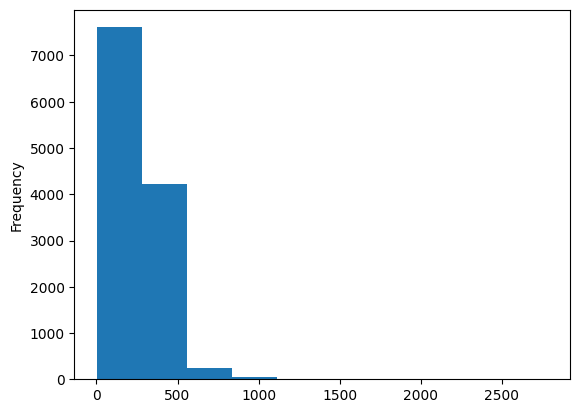

In [ ]:
# check the distribution of length of the sentence
df.sentence.apply(lambda x: len(''.join(jieba.cut(x, cut_all=False)))).plot(kind='hist')
# since the most length are below 500, so in thie project I will use truncation and padding

<Axes: >

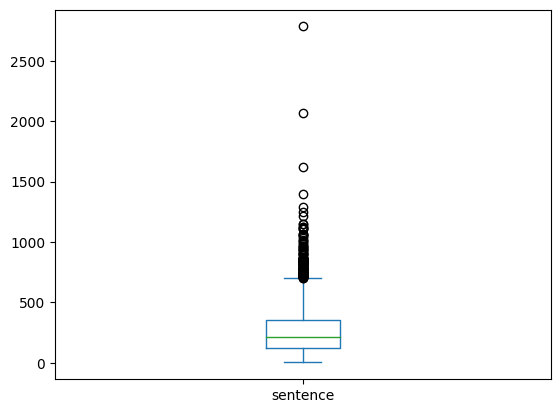

In [ ]:
df.sentence.apply(lambda x: len(''.join(jieba.cut(x, cut_all=False)))).plot(kind='box')

<Axes: ylabel='label'>

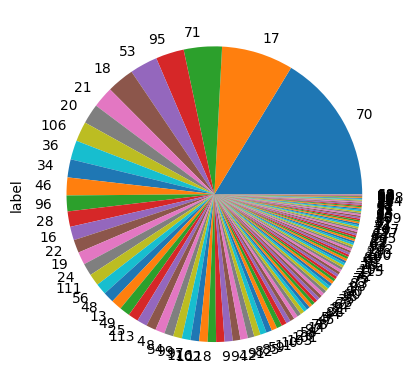

In [ ]:
# Label count by pie chart
df.label.value_counts().plot(kind='pie')

# Data imbalance weight calculate

In [ ]:
# Get the weight for focal loss from the label frequency
freq = 0.01/df.label.value_counts(normalize=True).sort_index()
weight_lable = torch.FloatTensor(freq.values).to("cuda")
freq

0      6.066500
1      3.279189
2      3.676667
3      6.066500
4      0.940543
         ...   
114    9.333077
115    3.791563
116    1.064298
117    5.275217
118    1.093063
Name: label, Length: 119, dtype: float64

# Data split

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.2, random_state=35)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

In [ ]:
train

,label,sentence
0,70,软件简介一键投影是一款面向教育教学培训商务报告的用户提供屏幕与屏幕之间投影服务具有无线传屏跨...
1,53,轻轻家教中小学上门在线全科辅导升学补习答疑提分必备备战小升初中考高考快找轻轻家教轻轻助你冲刺...
2,25,宜宾零距离大宜宾交友神器同城约会爆料社区吃喝玩乐五折卡买房子装房子一站服务新潮自拍分享三江城...
3,70,浮萍星空动态壁纸是一款画面十分唯美可爱的卡通风月色星空动态壁纸作品宁静的星空下透明的玻璃瓶里...
4,17,享聊定位于一款创新的游戏及视频交友软件在这里你可以和同城好友一起玩你画我猜趣味答题游戏玩的开...
...,...,...
9701,105,优信拍是专业提供二手车电子化车辆交易服务的供应商是国内领先的二手车网络交易企业我们的核心业务...
9702,118,习行顶岗实习管理以新的职业院校学生顶岗实习管理规定为依据以职业院校实践教学典型操作流程和制度...
9703,14,我叫2高清视频软件介绍我叫2是一部由七彩映画出品的原创3网络系列动画至今仍在连载被众多网友冠...
9704,53,本书是根据多种版本初中数学教材编写而成注重基础知识的系统学习注意知识间的前后融合对教材中的知...


In [ ]:
train_InputExamples = train.apply(lambda x: InputExample(guid=None,
                                                                   text_a = x['sentence'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)

val_InputExamples = val.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x['sentence'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)

# Vanila Bert Model

In [ ]:
# 1. define the model
class BertForClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = 119

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,  # the tnput ids
        attention_mask=None,   # the mask of attention
        token_type_ids=None,    # [CLS]A[SEP]B[SEP] 
        position_ids=None,     # positional id
        head_mask=None,       # mask of head
        inputs_embeds=None,   # input ids or embeddings
        labels=None,          # label
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output, pooled_output=outputs[:2]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        
        outputs = (logits, pooled_output, sequence_output,)

        if labels is not None:
            
            if self.num_labels == 1:
                #  regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                ''' 
                The imbalance Loss function
                '''
                # loss_fct = CrossEntropyLoss()
                # loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
                ''' 
                The Focal Loss function
                '''
                m = torch.nn.Softmax(dim=-1)
                focal_loss = FocalLoss(gamma=0.7, weights=weight_lable)
                loss = focal_loss(m(logits.view(-1, self.num_labels)), labels.view(-1))
            outputs = (loss,) + outputs

        
        return outputs  # loss, logits, pooled_output, sequence_output

In [ ]:
bert_class, tokenizer_class = 'hfl/chinese-roberta-wwm-ext-large','hfl/chinese-roberta-wwm-ext-large'
bert_pre = 'hfl/chinese-roberta-wwm-ext'
MODEL_CLASSES={
    "bert":(BertConfig,BertTokenizer),
}

args={"model_name_or_path": bert_pre,
    "config_name": bert_pre,
    "tokenizer_name": bert_pre,
      }

config_class, tokenizer_class = MODEL_CLASSES["bert"]
model_class=BertForClassification


config = config_class.from_pretrained(
    args["config_name"],

)
tokenizer = tokenizer_class.from_pretrained(
    args["tokenizer_name"],
    do_lower_case=True,
)
model = model_class.from_pretrained(
    args["model_name_or_path"],
    from_tf=bool(".ckpt" in args["model_name_or_path"]),
    config=config,
    cache_dir=None,
)
model.to("cuda")

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertForClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForClassification were not initialized from the model checkpoint at hfl/chinese-roberta-w

BertForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# 2.Prepare the data
MAX_SEQ_LENGTH = 512
train_features = convert_examples_to_features(train_InputExamples,
                                              tokenizer, 
                                              label_list= [i for i in range(119)], 
                                              output_mode="classification", 
                                              max_length=MAX_SEQ_LENGTH )

In [ ]:
 # Check the data
print("Sentence-1: ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].attention_mask)
print("-"*30)
print("Token type IDS : ", train_features[0].token_type_ids)
print("-"*30)
print("Label : ", train_features[0].label)
print("-"*30)
print("-"*30)
print("Sentence-2: ", train_InputExamples.iloc[1].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[1].text_a))
print("-"*30)
print("Input IDs : ", train_features[1].input_ids)
print("-"*30)
print("Input Masks : ", train_features[1].attention_mask)
print("-"*30)
print("Token type IDS : ", train_features[1].token_type_ids)
print("-"*30)
print("Label : ", train_features[1].label)
print("-"*30)

In [ ]:
input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
attention_mask = torch.tensor([f.attention_mask for f in train_features], dtype=torch.long)
token_type_ids = torch.tensor([f.token_type_ids for f in train_features], dtype=torch.long)
the_labels = torch.tensor([f.label for f in train_features], dtype=torch.long)

# Pass the data to the Dataset Class
dataset = TensorDataset(input_ids, attention_mask, token_type_ids, the_labels)

In [ ]:
# 3.define the train function
def train(train_dataset,model,tokenizer, epoch):
    no_decay=["bias","LayerNorm.weight"]
    optimizer_grouped_parameters=[
        {
            "params":[p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay":0.0,

        },
        {
            "params": [p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay":0.0
        },
    ]

    
    t_total=len(train_dataset)// epoch
    optimizer=AdamW(optimizer_grouped_parameters,lr=2e-5,eps=1e-8)
    # scheduler to set the learning rate
    scheduler=get_linear_schedule_with_warmup(
        optimizer,num_warmup_steps=0,num_training_steps=t_total
        )
    


    epochs_trained=0
    global_step=0
    steps_trained_in_current_epoch=0

    tr_loss,logging_loss=0.0,0.0
    model.zero_grad()
    train_iterator=trange(epochs_trained,epoch,desc="Epoch",disable=False)
    

    for k in train_iterator: 
    
        #shuffle the training data
        train_sampler=RandomSampler(train_dataset)
        train_dataloader=DataLoader(train_dataset,sampler=train_sampler,batch_size=8)
        epoch_iterator=tqdm(train_dataloader,position = 0, leave = True)

        for step,batch in enumerate(epoch_iterator): 
            if steps_trained_in_current_epoch>0:
                steps_traned_in_current_epoch-=1
                continue

            model.train()
            batch=tuple(t.to("cuda") for t in batch)
            
            # batch = input_ids, attention_mask, token_type_ids, the_labels
            inputs={"input_ids": batch[0],"attention_mask": batch[1],"token_type_ids": batch[2], "labels": batch[3]}
   
            outputs = model(**inputs)
            loss=outputs[0]
            
 
            loss.backward()

            tr_loss+=loss.item()
            epoch_iterator.set_description(f'Epoch [{k+1}/{epoch}]')
            epoch_iterator.set_postfix(loss = tr_loss/(global_step+1))#, acc = running_acc
            if (step+1)%1==0:
                torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

                optimizer.step()
                scheduler.step()
                model.zero_grad()
                global_step+=1



    return global_step,tr_loss/global_step

In [ ]:
# 4.Training 
epoch = 10
train(dataset,model,tokenizer,epoch)

Epoch: 100%|██████████| 9/9 [2:20:07<00:00, 934.16s/it]


(10926, 1.7919352427629593)

In [ ]:

# epoch = 5
# train(dataset,model,tokenizer,epoch)

Epoch: 100%|██████████| 5/5 [1:17:20<00:00, 928.15s/it]


(6070, 1.3404769722464351)

In [ ]:
# 5.save the model
import os
model.save_pretrained("/content/drive/MyDrive/Wisers/classification_models_vanila_focal/")
tokenizer.save_pretrained("/content/drive/MyDrive/Wisers/classification_models_vanila_focal/")

torch.save(args,os.path.join("/content/drive/MyDrive/Wisers/classification_models_vanila_focal/","training_args.bin"))

##  Valid and test the model

In [ ]:
  # 1. load the model
args_eval={"model_name_or_path": "/content/drive/MyDrive/Wisers/classification_models_vanila/",
    "config_name": "/content/drive/MyDrive/Wisers/classification_models_vanila/",
    "tokenizer_name": "/content/drive/MyDrive/Wisers/classification_models_vanila/",
      }

config_class, tokenizer_class = MODEL_CLASSES["bert"]
model_class=BertForClassification


config = config_class.from_pretrained(
    args_eval["config_name"],
    finetuning_task="", 
    cache_dir=None,
)
tokenizer = tokenizer_class.from_pretrained(
    args_eval["tokenizer_name"],
    do_lower_case=True,
    cache_dir=None,
)
model = model_class.from_pretrained(
    args_eval["model_name_or_path"],
    from_tf=bool(".ckpt" in args_eval["model_name_or_path"]),
    config=config,
    cache_dir=None,
)


model.to("cuda")

BertForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# 2.define the performance matrix
from sklearn.metrics import f1_score, precision_score, recall_score

def simple_accuracy(preds, labels):
    return (preds == labels).mean()
def acc_and_f1(preds, labels):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds, average='macro')
    pre = precision_score(y_true=labels, y_pred=preds, average='macro')
    rec = recall_score(y_true=labels, y_pred=preds, average='macro')
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
        "precision": pre,
        "recall": rec,
    }





def evaluate(model, tokenizer, eval_dataset):


    print("***** Running evaluation  *****")
    print("  Num examples = %d", len(eval_dataset))
    print("  Batch size = %d", 16)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None

    eval_sampler =RandomSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=16)

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to("cuda") for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = np.argmax(preds, axis=1)

    results = acc_and_f1(preds, out_label_ids)




    return results,eval_loss

In [ ]:
# 3. generate the valid data
val_features = convert_examples_to_features(val_InputExamples, 
                                            tokenizer, 
                                            label_list=[i for i in range(119)], 
                                            output_mode="classification",  
                                            max_length=MAX_SEQ_LENGTH )


val_input_ids = torch.tensor([f.input_ids for f in val_features], dtype=torch.long)
val_attention_mask = torch.tensor([f.attention_mask for f in val_features], dtype=torch.long)
val_token_type_ids = torch.tensor([f.token_type_ids for f in val_features], dtype=torch.long)
val_the_labels = torch.tensor([f.label for f in val_features], dtype=torch.long)


eval_dataset = TensorDataset(val_input_ids, val_attention_mask, val_token_type_ids, val_the_labels)

/usr/local/lib/python3.9/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [ ]:
# 4. Results
# Vanila without focal loss:
# Loss:  1.6536370735419423
# {'acc': 0.6205191594561187, 'f1': 0.36022517460279935, 'acc_and_f1': 0.490372167029459, 'precision': 0.3959976441357366, 'recall': 0.3790042607524597}

results,eval_loss = evaluate(model, tokenizer, eval_dataset)
print()
print("Loss: ",eval_loss)
print(results)

***** Running evaluation  *****
  Num examples = %d 2427
  Batch size = %d 16


Evaluating: 100%|██████████| 152/152 [01:24<00:00,  1.79it/s]


Loss:  2.0639153283677603
{'acc': 0.5620107128141739, 'f1': 0.3981786952861361, 'acc_and_f1': 0.480094704050155, 'precision': 0.37928323513903633, 'recall': 0.4786130427142046}



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## In dev dataset

In [ ]:
# In dev dataset
dev_df = pd.read_json('/content/drive/MyDrive/Wisers/iflytek_public/dev.json',lines=True)
dev_df.drop(columns = ['label_des'] , inplace = True)


sen_stop = []
for s in dev_df['sentence']:
    sen_stop.append( clear_character(''.join([w for w in s.split() if w not in stop_words])))
dev_df['sentence'] = sen_stop
# dev_df.head()

dev_InputExamples = dev_df.apply(lambda x: InputExample(guid=None,
                                                                   text_a = x['sentence'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)

dev_features = convert_examples_to_features(dev_InputExamples, 
                                            tokenizer, 
                                            label_list=[i for i in range(119)], 
                                            output_mode="classification",  
                                            max_length=MAX_SEQ_LENGTH )


dev_input_ids = torch.tensor([f.input_ids for f in dev_features], dtype=torch.long)
dev_attention_mask = torch.tensor([f.attention_mask for f in dev_features], dtype=torch.long)
dev_token_type_ids = torch.tensor([f.token_type_ids for f in dev_features], dtype=torch.long)
dev_the_labels = torch.tensor([f.label for f in dev_features], dtype=torch.long)


dev_eval_dataset = TensorDataset(dev_input_ids, dev_attention_mask, dev_token_type_ids, dev_the_labels)
results,eval_loss = evaluate(model, tokenizer, dev_eval_dataset)
print()
print("Loss: ",eval_loss)
print(results)

/usr/local/lib/python3.9/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


***** Running evaluation  *****
  Num examples = %d 2599
  Batch size = %d 16


Evaluating: 100%|██████████| 163/163 [01:30<00:00,  1.79it/s]


Loss:  2.7978546992401405
{'acc': 0.6017699115044248, 'f1': 0.3413549346144341, 'acc_and_f1': 0.47156242305942947, 'precision': 0.36384067659579633, 'recall': 0.3696828764786109}



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Vanila + LSTM

In [ ]:
# 1.Define the model
class BertLSTMForClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = 119

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.lstm =  nn.LSTM(input_size=config.hidden_size, hidden_size=config.hidden_size,
                          num_layers=2, batch_first=True,bidirectional=True) #lstm
        self.classifier = nn.Linear(config.hidden_size*2, self.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,  # the tnput ids
        attention_mask=None,   # the mask of attention
        token_type_ids=None,    # [CLS]A[SEP]B[SEP] 
        position_ids=None,     # positional id
        head_mask=None,       # mask of head
        inputs_embeds=None,   # input ids or embeddings
        labels=None,          # label
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output, pooled_output=outputs[:2] #sequence_output has the following shape: (batch_size, sequence_length 512, config.hidden_size)
        lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
        hidden = torch.cat((lstm_output[:,-1, :config.hidden_size],lstm_output[:,0, config.hidden_size:]),dim=-1)
        hidden = self.dropout(hidden)
        logits = self.classifier(hidden)

        
        outputs = (logits, pooled_output, sequence_output,)

        if labels is not None:
            
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                # loss_fct = CrossEntropyLoss()
                # loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
                m = torch.nn.Softmax(dim=-1)
                focal_loss = FocalLoss(gamma=0.7, weights=weight_lable)
                loss = focal_loss(m(logits.view(-1, self.num_labels)), labels.view(-1))
            outputs = (loss,) + outputs

        
        return outputs  # loss, logits, pooled_output, sequence_output

In [ ]:
bert_class, tokenizer_class = 'hfl/chinese-roberta-wwm-ext-large','hfl/chinese-roberta-wwm-ext-large'
bert_pre = 'hfl/chinese-roberta-wwm-ext'
MODEL_CLASSES={
    "bert":(BertConfig,BertTokenizer),
}

args={"model_name_or_path": bert_pre,
    "config_name": bert_pre,
    "tokenizer_name": bert_pre,
      }

config_class, tokenizer_class = MODEL_CLASSES["bert"]
model_class=BertLSTMForClassification


config = config_class.from_pretrained(
    args["config_name"],

)
tokenizer = tokenizer_class.from_pretrained(
    args["tokenizer_name"],
    do_lower_case=True,
)
model = model_class.from_pretrained(
    args["model_name_or_path"],
    from_tf=bool(".ckpt" in args["model_name_or_path"]),
    config=config,
    cache_dir=None,
)
model.to("cuda")

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertLSTMForClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertLSTMForClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLSTMForClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLSTMForClassification were not initialized from the model checkpoint at hfl/c

BertLSTMForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
# 2.Prepare the data
MAX_SEQ_LENGTH = 512
train_features = convert_examples_to_features(train_InputExamples,
                                              tokenizer, 
                                              label_list= [i for i in range(119)], 
                                              output_mode="classification", 
                                              max_length=MAX_SEQ_LENGTH )

/usr/local/lib/python3.9/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [ ]:
input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
attention_mask = torch.tensor([f.attention_mask for f in train_features], dtype=torch.long)
token_type_ids = torch.tensor([f.token_type_ids for f in train_features], dtype=torch.long)
the_labels = torch.tensor([f.label for f in train_features], dtype=torch.long)

dataset = TensorDataset(input_ids, attention_mask, token_type_ids, the_labels)

In [ ]:
# 3.define the train function
def train(train_dataset,model,tokenizer, epoch):
    no_decay=["bias","LayerNorm.weight"]
    optimizer_grouped_parameters=[
        {
            "params":[p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay":0.0,

        },
        {
            "params": [p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay":0.0
        },
    ]

    
    t_total=len(train_dataset)// epoch
    optimizer=AdamW(optimizer_grouped_parameters,lr=2e-5,eps=1e-8)
     # scheduler to set the learning rate
    scheduler=get_linear_schedule_with_warmup(
        optimizer,num_warmup_steps=0,num_training_steps=t_total
        )
    


    epochs_trained=0
    global_step=0
    steps_trained_in_current_epoch=0

    tr_loss,logging_loss=0.0,0.0
    model.zero_grad()
    train_iterator=trange(epochs_trained,epoch,desc="Epoch",disable=False)
    

    for k in train_iterator: 
    
        # shuffle the data
        train_sampler=RandomSampler(train_dataset)
        train_dataloader=DataLoader(train_dataset,sampler=train_sampler,batch_size=8)
        epoch_iterator=tqdm(train_dataloader,position = 0, leave = True)

        for step,batch in enumerate(epoch_iterator): 
            if steps_trained_in_current_epoch>0:
                steps_traned_in_current_epoch-=1
                continue

            model.train()
            batch=tuple(t.to("cuda") for t in batch)
            
            # batch =  input_ids, attention_mask, token_type_ids, the_labels
            inputs={"input_ids": batch[0],"attention_mask": batch[1],"token_type_ids": batch[2], "labels": batch[3]}
   
            outputs = model(**inputs)
            loss=outputs[0]
            
 
            loss.backward()

            tr_loss+=loss.item()
            epoch_iterator.set_description(f'Epoch [{k+1}/{epoch}]')
            epoch_iterator.set_postfix(loss = tr_loss/(global_step+1))#, acc = running_acc
            if (step+1)%1==0:
                torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

                optimizer.step()
                scheduler.step()
                model.zero_grad()
                global_step+=1


    return global_step,tr_loss/global_step

In [ ]:
# 4.training
epoch = 10
train(dataset,model,tokenizer,epoch)

Epoch: 100%|██████████| 10/10 [3:48:44<00:00, 1372.50s/it]


(12140, 2.6808030420905085)

In [ ]:
# 5.save the model
import os
model.save_pretrained("/content/drive/MyDrive/Wisers/classification_models_lstm_focal/")
tokenizer.save_pretrained("/content/drive/MyDrive/Wisers/classification_models_lstm_focal/")

torch.save(args,os.path.join("/content/drive/MyDrive/Wisers/classification_models_lstm_focal/","training_args.bin"))

## Valid and test the model

In [ ]:
  # 1. load the model
args_eval={"model_name_or_path": "/content/drive/MyDrive/Wisers/classification_models_lstm_focal/",
    "config_name": "/content/drive/MyDrive/Wisers/classification_models_lstm_focal/",
    "tokenizer_name": "/content/drive/MyDrive/Wisers/classification_models_lstm_focal/",
      }

config_class, tokenizer_class = MODEL_CLASSES["bert"]
model_class=BertLSTMForClassification


config = config_class.from_pretrained(
    args_eval["config_name"],
    finetuning_task="", 
    cache_dir=None,
)
tokenizer = tokenizer_class.from_pretrained(
    args_eval["tokenizer_name"],
    do_lower_case=True,
    cache_dir=None,
)
model = model_class.from_pretrained(
    args_eval["model_name_or_path"],
    from_tf=bool(".ckpt" in args_eval["model_name_or_path"]),
    config=config,
    cache_dir=None,
)


model.to("cuda")

BertLSTMForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
# 2.define the performance matrix
from sklearn.metrics import f1_score, precision_score, recall_score

def simple_accuracy(preds, labels):
    return (preds == labels).mean()
def acc_and_f1(preds, labels):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds, average='macro')
    pre = precision_score(y_true=labels, y_pred=preds, average='macro')
    rec = recall_score(y_true=labels, y_pred=preds, average='macro')
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
        "precision": pre,
        "recall": rec,
    }





def evaluate(model, tokenizer, eval_dataset):


    print("***** Running evaluation  *****")
    print("  Num examples = %d", len(eval_dataset))
    print("  Batch size = %d", 16)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None

    eval_sampler =RandomSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=16)

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to("cuda") for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = np.argmax(preds, axis=1)

    results = acc_and_f1(preds, out_label_ids)




    return results,eval_loss

In [ ]:
# 3.generate the valid data
val_features = convert_examples_to_features(val_InputExamples, 
                                            tokenizer, 
                                            label_list=[i for i in range(119)], 
                                            output_mode="classification",  
                                            max_length=MAX_SEQ_LENGTH )


val_input_ids = torch.tensor([f.input_ids for f in val_features], dtype=torch.long)
val_attention_mask = torch.tensor([f.attention_mask for f in val_features], dtype=torch.long)
val_token_type_ids = torch.tensor([f.token_type_ids for f in val_features], dtype=torch.long)
val_the_labels = torch.tensor([f.label for f in val_features], dtype=torch.long)


eval_dataset = TensorDataset(val_input_ids, val_attention_mask, val_token_type_ids, val_the_labels)

In [ ]:
# 4. results
results,eval_loss = evaluate(model, tokenizer, eval_dataset)
print()
print("Loss: ",eval_loss)
print(results)

***** Running evaluation  *****
  Num examples = %d 2427
  Batch size = %d 16


Evaluating: 100%|██████████| 152/152 [01:51<00:00,  1.36it/s]


Loss:  2.8130161393629876
{'acc': 0.4717758549649773, 'f1': 0.25236149647113204, 'acc_and_f1': 0.3620686757180547, 'precision': 0.2852672632806594, 'recall': 0.33167952139601986}



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## In dev dataset

In [ ]:
dev_df = pd.read_json('/content/drive/MyDrive/Wisers/iflytek_public/dev.json',lines=True)
dev_df.drop(columns = ['label_des'] , inplace = True)

sen_stop = []
for s in dev_df['sentence']:
    sen_stop.append( clear_character(''.join([w for w in s.split() if w not in stop_words])))
dev_df['sentence'] = sen_stop


dev_InputExamples = dev_df.apply(lambda x: InputExample(guid=None,
                                                                   text_a = x['sentence'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)

dev_features = convert_examples_to_features(dev_InputExamples, 
                                            tokenizer, 
                                            label_list=[i for i in range(119)], 
                                            output_mode="classification",  
                                            max_length=MAX_SEQ_LENGTH )


dev_input_ids = torch.tensor([f.input_ids for f in dev_features], dtype=torch.long)
dev_attention_mask = torch.tensor([f.attention_mask for f in dev_features], dtype=torch.long)
dev_token_type_ids = torch.tensor([f.token_type_ids for f in dev_features], dtype=torch.long)
dev_the_labels = torch.tensor([f.label for f in dev_features], dtype=torch.long)


dev_eval_dataset = TensorDataset(dev_input_ids, dev_attention_mask, dev_token_type_ids, dev_the_labels)
results,eval_loss = evaluate(model, tokenizer, dev_eval_dataset)
print()
print("Loss: ",eval_loss)
print(results)

/usr/local/lib/python3.9/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


***** Running evaluation  *****
  Num examples = %d 2599
  Batch size = %d 16


Evaluating: 100%|██████████| 163/163 [01:59<00:00,  1.36it/s]


Loss:  3.029639141691243
{'acc': 0.4636398614851866, 'f1': 0.24090385262203434, 'acc_and_f1': 0.35227185705361047, 'precision': 0.2523091215315878, 'recall': 0.3146456527980764}



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
